# Summary evaluation from Benchmark_llm_summarization

Benchmarking Large Language Models for News Summarization


Summarization is a core ability in LLMs for the RAGs system which can be explained as the ability of extracting important information from the given cotext.


In this study, this SUM tasks are implemented by the following steps:

1. Collect all questions from the dataset and then formulate prompt tempelate with specific prompts to let the model generate summary.

| prompt_question                                                                                                                          | Answer | Evaluation_prompt | Evaluation_results |
|--------------------------------------------------------------------------------------------------------------------------------------------|--------|------------------|--------------------|
|You are a writer who is good at summarizing articles. Instruction: Summarize the following article in 1 to 3 sentences. **Article:** Nick Scholfield is lined up to ride Spring Heeled in the Grand National at Aintree on April 11. Nick Scholfield has been lined up to ride Jim Culloty’s Spring Heeled in the Crabbie’s Grand National at Aintree on Saturday week. Scholfield had been expected to partner Paul Nicholls-trained Sam Winner, who was pulled up in the Cheltenham Gold Cup, in the £1million race. But the champion trainer  said on Wednesday it was unfair to tie Scholfield down to a gelding which is far from certain to run when the mount on another leading definite contender is being offered. Scholfield, who has ridden in six Nationals and finished third in 2013 on Teaforthree, will travel to Ireland to sit on Spring Heeled at Culloty’s County Cork stable on Friday. Luke Morris became the first jockey to ride 100 winners during an All Weather Flat racing season when a double at Chelmsford on Wednesday aboard Giantouch and Middle East Pearl carried him to 101 successes for the campaign.|Nick Scholfield has been selected to ride Jim Culloty's horse Spring Heeled in the Crabbie's Grand National at Aintree on April 11. Scholfield was previously expected to ride Paul Nicholls-trained Sam Winner, but Nicholls has decided to give Spring Heeled a National preparation instead. Spring Heeled has only run once since last season, finishing fourth in a Bobbyjo Chase at Fairyhouse in February. | None | rouge_l_fmeasure


1. Then get the response comparing the generated responses and human written responses.
2. Finally, do the statistical analysis and causal modeling for future usage.




In [14]:
import pandas as pd
import time
from tqdm import tqdm
import os
import re
import string
from collections import Counter
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from rouge_score import rouge_scorer
from bert_score import score
from nltk.translate import meteor_score
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
import matplotlib.pyplot as plt
from openai import OpenAI
from bert_score import BERTScorer


file_name = "exp_result_Mixtral-8x7B-Instruct-v0.1_20240507200347.csv"
foler_path = "data/SUM"

output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
bleurt_model_name = "Elron/bleurt-large-512"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

In [15]:
def calculate_rouge_scores(row):
    answer = row["pure_response"]
    reference = row["humman_summary"]
    scorer = rouge_scorer.RougeScorer(["rougeL"])
    scores = scorer.score(answer, reference)
    precision = scores["rougeL"][0]
    recall = scores["rougeL"][1]
    fmeasure = scores["rougeL"][2]
    return pd.Series({"precision": precision, "recall": recall, "fmeasure": fmeasure})


def bart_score(candidate, reference):
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
    inputs = tokenizer(candidate, return_tensors="pt", max_length=1024, truncation=True)
    labels = tokenizer(reference, return_tensors="pt", max_length=1024, truncation=True)
    score = model(**inputs, labels=labels)["loss"].item()
    return score


def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


def bert_score(row, scorer):
    candidate = row["pure_response"]
    reference = row["humman_summary"]
    P, R, F1 = scorer.score([candidate], [reference])
    return P[0].item(), R[0].item(), F1[0].item()


def meteor_score_evaluate(row):
    candidate = row["pure_response"]
    reference = row["humman_summary"]
    score = meteor_score.meteor_score([reference], candidate)
    return score

In [ ]:
from tqdm import tqdm

tqdm.pandas()
scorer = BERTScorer(model_type="bert-large-uncased")
_data["pure_response"] = _data.progress_apply(extract_pure_response, axis=1)
new_columns = _data.progress_apply(calculate_rouge_scores, axis=1)
_data["rouge_l_precision"] = new_columns["precision"]
_data["rouge_l_recall"] = new_columns["recall"]
_data["rouge_l_fmeasure"] = new_columns["fmeasure"]
_data[["bert_P", "bert_R", "bert_F1"]] = _data.progress_apply(
    lambda row: bert_score(row, scorer), axis=1, result_type="expand"
)
_data.to_csv(output_path, index=False)

# Draw all the models' output and evaluations together

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
output_photo_name = f"SUM_{current_time_str}.svg"
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}

marker_map = {
    "Llama-2-7b-chat-hf": ".",
    "Llama-2-13b-chat-hf": "*",
    "Llama-2-70b-chat-hf": "o",
    "Meta-Llama-3-8B-Instruct": "+",
    "Meta-Llama-3-70B-Instruct": "^",
    "Mistral-7B-Instruct-v0.2": "<",
    "Mixtral-8x7B-Instruct-v0.1": ">",
}

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]
color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
}

folder_path = "data/SUM"
output_photo_name = f"SUM_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["model_encoded"] = df["model_name"].map(model_map)

In [2]:
df[df["pure_response"].isna()]

,Temperature,article,humman_summary,initial_prompt,llama2_chat_initial_prompt,llama3_chat_initial_prompt,mixtral_instruct_initial_prompt,SYSTEM_MESSAGE,USER_MESSAGE,generated_response,...,pure_response,rouge_l_precision,rouge_l_recall,rouge_l_fmeasure,bert_P,bert_R,bert_F1,model_name,weight_size,model_encoded
4272,0.1,The president of the MGM Grand is making a sol...,The MGM Grand is getting ready for the fight o...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,<s>[INST]\nYou are a writer who is good at sum...,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Mixtral-8x7B-Instruct-v0.1,56,6
4273,0.1,The president of the MGM Grand is making a sol...,The MGM Grand resort in Las Vegas is preparing...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,<s>[INST]\nYou are a writer who is good at sum...,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Mixtral-8x7B-Instruct-v0.1,56,6
4274,0.1,The president of the MGM Grand is making a sol...,The MGM Grand is hosting what's being called t...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,<s>[INST]\nYou are a writer who is good at sum...,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Mixtral-8x7B-Instruct-v0.1,56,6
4574,0.4,The president of the MGM Grand is making a sol...,The MGM Grand is getting ready for the fight o...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,<s>[INST]\nYou are a writer who is good at sum...,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Mixtral-8x7B-Instruct-v0.1,56,6
4575,0.4,The president of the MGM Grand is making a sol...,The MGM Grand resort in Las Vegas is preparing...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,<s>[INST]\nYou are a writer who is good at sum...,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Mixtral-8x7B-Instruct-v0.1,56,6
4576,0.4,The president of the MGM Grand is making a sol...,The MGM Grand is hosting what's being called t...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,<s>[INST]\nYou are a writer who is good at sum...,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Mixtral-8x7B-Instruct-v0.1,56,6
4876,0.7,The president of the MGM Grand is making a sol...,The MGM Grand is getting ready for the fight o...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,<s>[INST]\nYou are a writer who is good at sum...,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Mixtral-8x7B-Instruct-v0.1,56,6
4877,0.7,The president of th

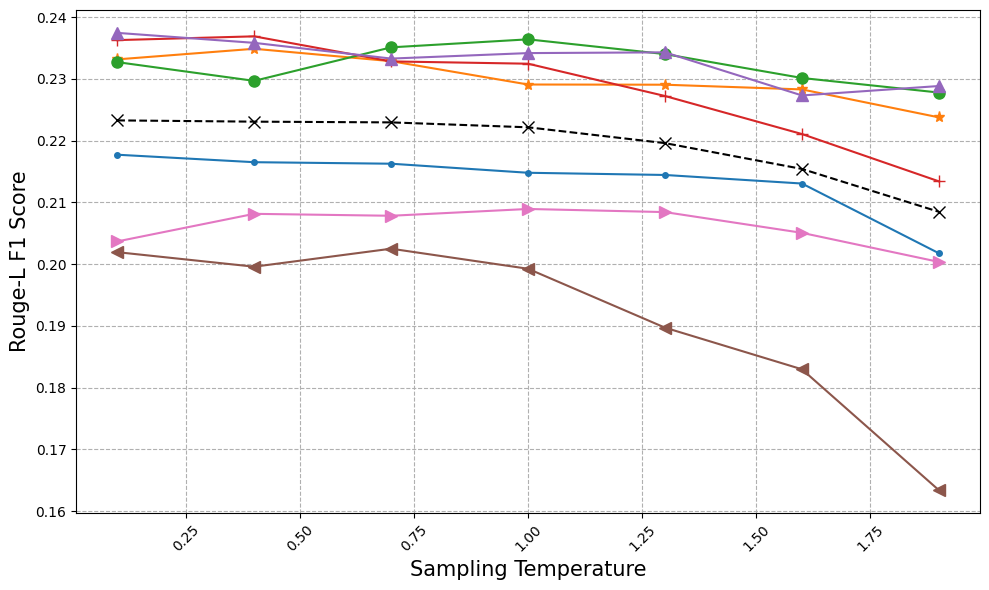

In [5]:
grouped_data = df.groupby(["model", "Temperature"])["rouge_l_fmeasure"].mean()

plt.figure(figsize=(10, 6))
for i, (model, color) in enumerate(color_map.items()):
    model_data = grouped_data[model]
    marker = marker_map[model]
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        color=color,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["rouge_l_fmeasure"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Sampling Temperature", fontsize=15)
plt.ylabel("Rouge-L F1 Score", fontsize=15)
# plt.title("Summarization\n Mean ROUGE-L F-measure with Temperature Across Models")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [4]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import pandas as pd


metric_name = "rouge_l_fmeasure"

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
# Calculate the results for all the models
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    # Normalised Accuracy Value So That The Accuracy Can Be comparable
    accuracy = model_data[metric_name].values
    accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
    # Calculate Correlation Metrics
    corr, p_value = spearmanr(temperatures, accuracy)
    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    beta_hat = model.params
    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


# The Calcluation for all the results accross the model
model_data = df
temperatures = model_data["Temperature"].values
accuracy = model_data[metric_name].values
accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
corr, p_value = spearmanr(temperatures, accuracy)
corr_pearson, p_value_pearson = pearsonr(temperatures, accuracy)
temperatures = sm.add_constant(temperatures)
model = sm.OLS(accuracy, temperatures).fit()
predictions = model.predict(temperatures)
se = np.sqrt(mean_squared_error(accuracy, predictions))
r_squared = model.rsquared
r_squared_adj = model.rsquared_adj
beta_hat = model.params
results.append(
    {
        "model": "All",
        "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
        "r_squared": f"{r_squared:.3f}",
        "r_squared_adj": f"{r_squared_adj:.3f}",
        "Spearman correlation Coefficient": f"{corr:.3f}",
        "P_value": f"{p_value:.3f}",
        "se": f"{se:.3f}",
        "beta_hat_0": f"{beta_hat[0]:.3f}",
        "beta_hat_1": f"{beta_hat[1]:.3f}",
    }
)


grouped_data = df.groupby(["Temperature"])[metric_name].mean().reset_index()

average_performance = grouped_data[metric_name].mean()

standard_deviation = grouped_data[metric_name].std()

range_value = grouped_data[metric_name].max() - grouped_data[metric_name].min()
statistical_range_percentage = (range_value / average_performance) * 100

coefficient_of_variation = (standard_deviation / average_performance) * 100

average_performance, standard_deviation, statistical_range_percentage, coefficient_of_variation

(0.2192745136495131,
 0.0055388157542644026,
 6.752959424171019,
 2.5259733391166512)

In [5]:
results_df = pd.DataFrame(results)
results_df

filtered_row = results_df[results_df["model"] == "All"]
spearman_coefficient = float(filtered_row["Spearman correlation Coefficient"].values[0])
p_value = float(filtered_row["P_value"].values[0])

print(f"Pearson correlation Coefficient: {corr_pearson:.3f}")
print(f"Pearson_p_value: {p_value_pearson:.3f}")
print(f"Average Performance: {average_performance:.3f}")
print(f"Spearman correlation Coefficient: {spearman_coefficient:.3f}")
print(f"p_value: {p_value:.3f}")
# print(f"Standard Deviation: {standard_deviation:.3f}")
print(f"Range Percentage: {statistical_range_percentage:.3f}%")
print(f"Coefficient of Variation: {coefficient_of_variation:.3f}")

Pearson correlation Coefficient: -0.067
Pearson_p_value: 0.000
Average Performance: 0.219
Spearman correlation Coefficient: -0.070
p_value: 0.000
Range Percentage: 6.753%
Coefficient of Variation: 2.526


In [3]:
grouped_data = (
    df.groupby(["model", "Temperature"])["rouge_l_fmeasure"].mean().reset_index()
)
df_pivot = grouped_data.pivot(
    index="model", columns="Temperature", values="rouge_l_fmeasure"
)
temperature_0_values = df_pivot[0.1]
max_abs_diffs = {}
for model in df_pivot.index:
    temp_0_value = temperature_0_values[model]
    abs_diffs = df_pivot.loc[model] - temp_0_value
    max_abs_diffs[model] = abs_diffs.abs().max() / temp_0_value * 100

print(max_abs_diffs)

{'Llama-2-13b-chat-hf': 4.028413535914123, 'Llama-2-70b-chat-hf': 2.1180119409698936, 'Llama-2-7b-chat-hf': 7.332090372504655, 'Meta-Llama-3-70B-Instruct': 4.269538868738907, 'Meta-Llama-3-8B-Instruct': 9.683251834677636, 'Mistral-7B-Instruct-v0.2': 19.09499214582704, 'Mixtral-8x7B-Instruct-v0.1': 2.5824323417181745}


In [37]:
rouped_data = df.groupby(["Temperature"])["rouge_l_fmeasure"].mean().reset_index()

# Calculating the Average Performance
average_performance = grouped_data["rouge_l_fmeasure"].mean()

# Calculating the Standard Deviation
standard_deviation = grouped_data["rouge_l_fmeasure"].std()

# Calculating the Statistical Range Percentage
range_value = (
    grouped_data["rouge_l_fmeasure"].max() - grouped_data["rouge_l_fmeasure"].min()
)
statistical_range_percentage = (range_value / average_performance) * 100

average_performance, standard_deviation, statistical_range_percentage

(0.2192745136495131, 0.0055388157542644026, 6.752959424171019)

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


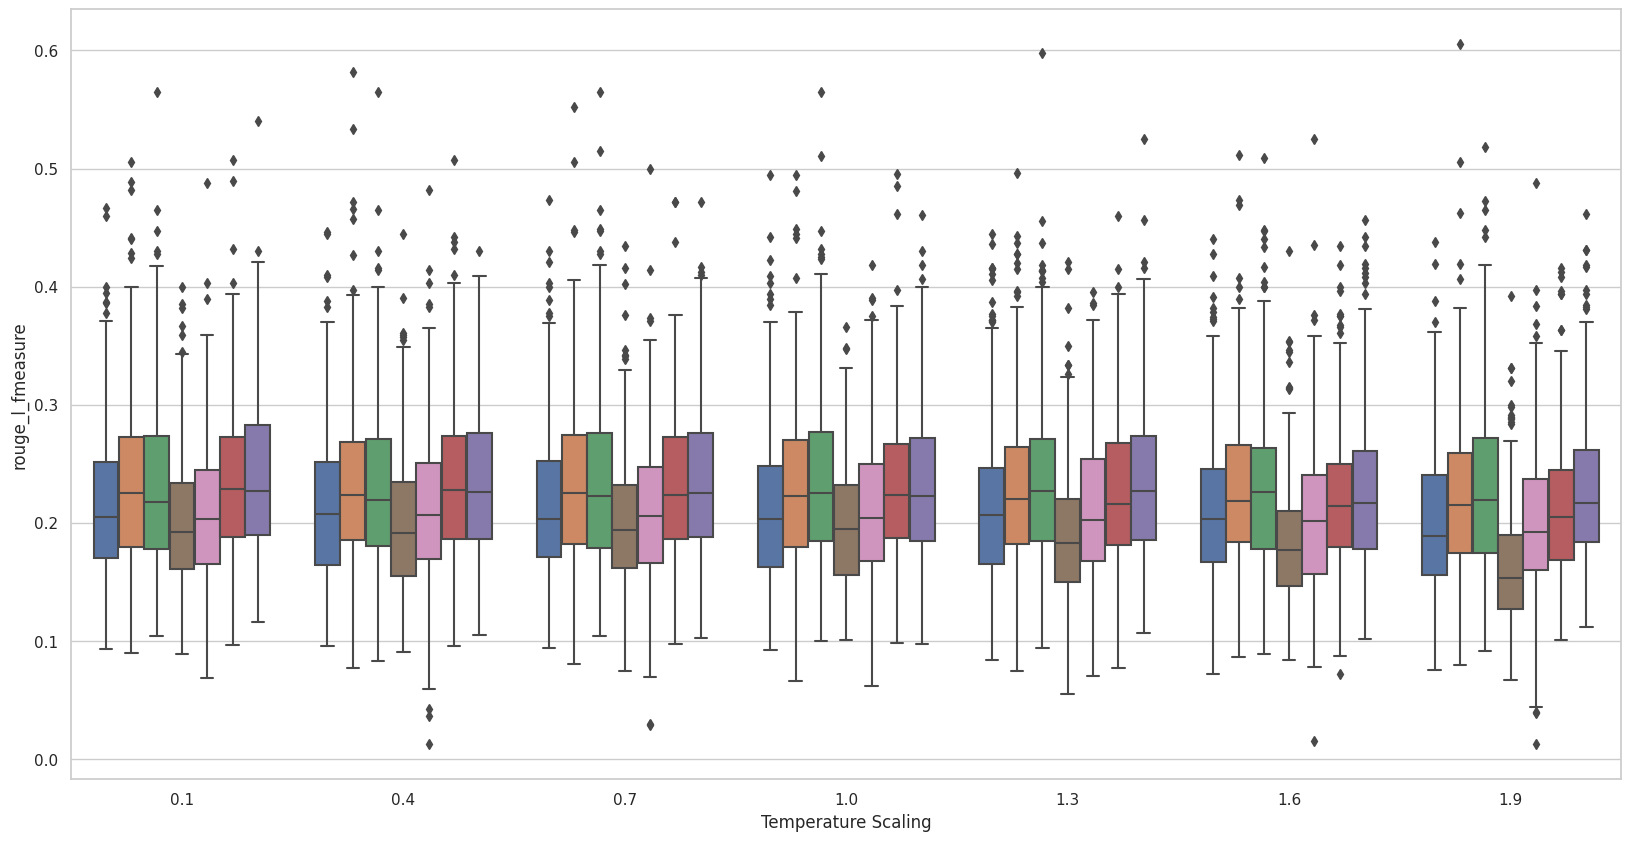

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
}
model_order = list(color_map.keys())
df["Temperature"] = df["Temperature"].round(1)

# Create a single plot
fig, ax = plt.subplots(figsize=(20, 10))

# Boxplot
sns.boxplot(
    x="Temperature",
    y="rouge_l_fmeasure",
    hue="model",
    data=df,
    palette=color_map,
    hue_order=model_order,
    ax=ax,
)

# ax.set_title("Boxplot Temperature vs spbleu")
ax.set_xlabel("Temperature Scaling")
ax.set_ylabel("rouge_l_fmeasure")
# ax.legend(loc="upper left")
ax.legend_.remove()
# Adjust layout
# plt.tight_layout()
plt.savefig("Summary_BOX_PLOT.svg", format="svg", bbox_inches="tight")
# Show the plot
plt.show()

In [3]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    accuracy = model_data["rouge_l_fmeasure"].values

    corr, p_value = spearmanr(temperatures, accuracy)

    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()

    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj

    beta_hat = model.params

    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


results_df = pd.DataFrame(results)


# for model in models:
#     # print(f"Model: {model}")
#     print(f"{correlations[model]}")
# print()
# for model in models:
#     print(f"{p_values[model]}")

# for model in models:
#     print(f"Model: {model}")
#     print(f"Kendall correlation: {correlations[model]}")
#     print(f"p-value: {p_values[model]}")
#     print(f"OLS summary:")
#     print(ols_results[model].summary())
#     print()

# results_df.to_csv("output.csv")